# library

In [1]:
import os
import random
import zipfile
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-10 02:59:21.152259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 02:59:21.152392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 02:59:21.297441: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths to the directories
base_path = '/kaggle/input/fruits-dataset-for-classification'
fresh_peaches_done = os.path.join(base_path, 'fresh_peaches_done')
fresh_pomegranates_done = os.path.join(base_path, 'fresh_pomegranates_done')
fresh_strawberries_done = os.path.join(base_path, 'fresh_strawberries_done')
rotten_peaches_done = os.path.join(base_path, 'rotten_peaches_done')
rotten_pomegranates_done = os.path.join(base_path, 'rotten_pomegranates_done')
rotten_strawberries_done = os.path.join(base_path, 'rotten_strawberries_done')

# Dictionary to hold the images list for each fruit type
fruit_images_dict = {
    'fresh_peaches': [],
    'fresh_pomegranates': [],
    'fresh_strawberries': [],
    'rotten_peaches': [],
    'rotten_pomegranates': [],
    'rotten_strawberries': []
}

# Get a list of image files from each fruit directory
for fruit_type, directory in [
    ('fresh_peaches', fresh_peaches_done),
    ('fresh_pomegranates', fresh_pomegranates_done),
    ('fresh_strawberries', fresh_strawberries_done),
    ('rotten_peaches', rotten_peaches_done),
    ('rotten_pomegranates', rotten_pomegranates_done),
    ('rotten_strawberries', rotten_strawberries_done)
]:
    fruit_images_dict[fruit_type] = [
        os.path.join(directory, file) for file in os.listdir(directory)
        if os.path.isfile(os.path.join(directory, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

# Define the target size for resizing
target_size = (100, 100)

# Dictionary to hold the resized images for each fruit type
resized_images = {}

# Load and resize a random image from each category
for fruit_type, images_list in fruit_images_dict.items():
    if images_list:  # Check if the list is not empty
        random_image_path = random.choice(images_list)
        img = Image.open(random_image_path)
        resized_images[fruit_type] = img.resize(target_size)
    else:
        print(f"No images found in directory for {fruit_type}")

# For example, to access the resized image for fresh peaches:
resized_fresh_peach_img = resized_images.get('fresh_peaches')


# Data preparetion

In [3]:
def load_and_preprocess_image(image_path):
    # Load the image in RGB mode
    image = Image.open(image_path).convert('RGB')
    # Resize the image
    resized_image = image.resize((100, 100))
    # Convert the image to numpy array and normalize
    image_array = np.array(resized_image) / 255.0
    return image_array

# Define a function to process images and extract labels and data
def process_images(image_list, label):
    data = [load_and_preprocess_image(image_path) for image_path in image_list]
    labels = [label] * len(image_list)  # Create a list of identical labels
    return data, labels

# Create lists to hold all the image data and labels
all_images_data = []
all_labels = []

# Define the directories for fresh and rotten fruits
fresh_dirs = [fresh_peaches_done, fresh_pomegranates_done, fresh_strawberries_done]
rotten_dirs = [rotten_peaches_done, rotten_pomegranates_done, rotten_strawberries_done]

# Map directory names to labels
fruit_label_mapping = {
    'fresh_peaches_done': 'fresh_peach',
    'fresh_pomegranates_done': 'fresh_pomegranate',
    'fresh_strawberries_done': 'fresh_strawberry',
    'rotten_peaches_done': 'rotten_peach',
    'rotten_pomegranates_done': 'rotten_pomegranate',
    'rotten_strawberries_done': 'rotten_strawberry'
}

# Define a function to process images and extract labels and data
def process_images(image_list, fruit_type):
    data = [load_and_preprocess_image(image_path) for image_path in image_list]
    labels = [fruit_type] * len(image_list)  # Assign the specific fruit label
    return data, labels

# Process all fruit images
for dir_name, fruit_type in fruit_label_mapping.items():
    directory = os.path.join(base_path, dir_name)
    image_list = [os.path.join(directory, file) for file in os.listdir(directory)
                  if os.path.isfile(os.path.join(directory, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))]
    data, labels = process_images(image_list, fruit_type)
    all_images_data.extend(data)
    all_labels.extend(labels)

# Convert to numpy arrays
all_images_data = np.array(all_images_data)
all_labels = np.array(all_labels)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images_data, encoded_labels, test_size=0.2, random_state=42
)

# Output the shape of the datasets and the number of images
print("Shape of train_images:", train_images.shape)
print("Shape of val_images:", val_images.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of val_labels:", val_labels.shape)

# Count the number of images for each type
unique_labels, counts_labels = np.unique(all_labels, return_counts=True)
print("Number of images per category:")
print(dict(zip(unique_labels, counts_labels)))


Shape of train_images: (1324, 100, 100, 3)
Shape of val_images: (331, 100, 100, 3)
Shape of train_labels: (1324,)
Shape of val_labels: (331,)
Number of images per category:
{'fresh_peach': 250, 'fresh_pomegranate': 311, 'fresh_strawberry': 250, 'rotten_peach': 343, 'rotten_pomegranate': 250, 'rotten_strawberry': 251}


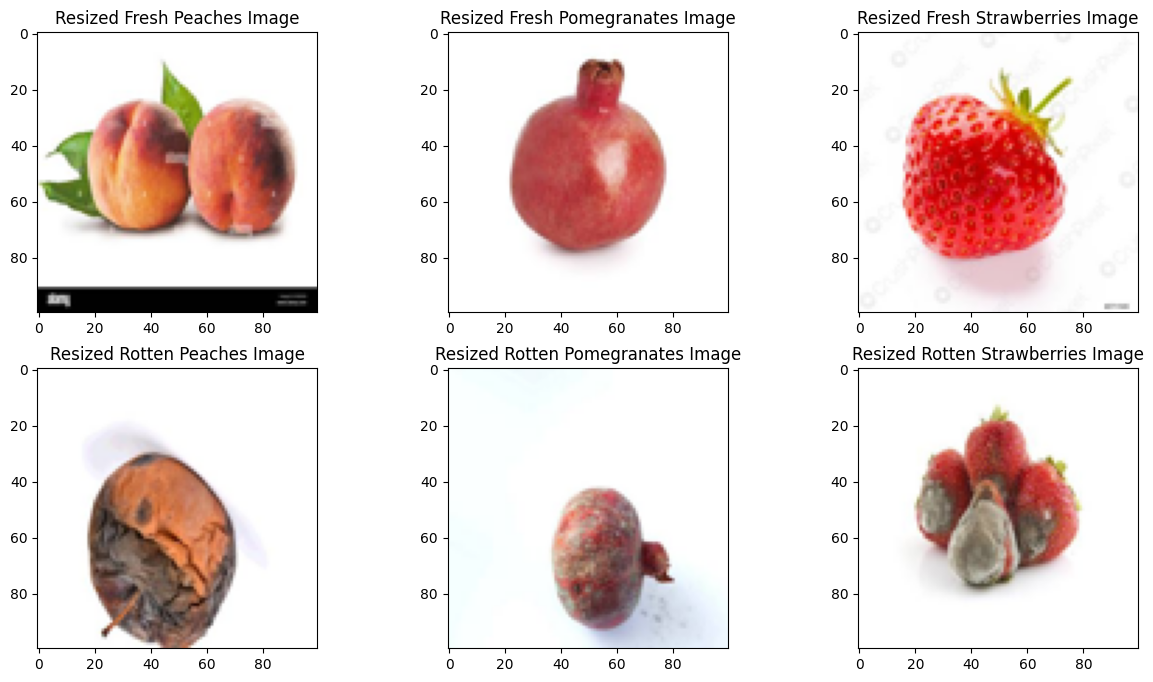

In [4]:
n_types = len(resized_images)
n_cols = 3 # Number of columns for the subplot
n_rows = int(n_types / n_cols) + (n_types % n_cols > 0)  # Calculate number of rows

plt.figure(figsize=(15, n_rows * 4))  # Adjust figure height based on rows

for i, (fruit_type, img) in enumerate(resized_images.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(img)
    plt.title(f"Resized {fruit_type.replace('_', ' ').title()} Image")  # Rotate title

plt.show()


# model

## **Data Augmentation**
* **Purpose:**Increases the diversity of the training dataset by applying random transformations like rotation, width and height shifting, shear, zoom, and horizontal flipping. This helps prevent overfitting and improves model generalization.

* **Implementation:** Utilizes ImageDataGenerator from Keras, which dynamically applies these transformations to the training images during the training process.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Assuming your image data is 100x100x3
cnn_model = create_cnn_model((100, 100, 3))
cnn_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,650,438 (25.37 MB)

 Trainable params: 6,650,438 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = cnn_model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.2257 - loss: 1.9760 - val_accuracy: 0.3897 - val_loss: 1.4625
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.4402 - loss: 1.3748 - val_accuracy: 0.5801 - val_loss: 1.0750
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - accuracy: 0.5953 - loss: 1.1146 - val_accuracy: 0.5801 - val_loss: 1.1387
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - accuracy: 0.6487 - loss: 0.9427 - val_accuracy: 0.6586 - val_loss: 0.9387
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - accuracy: 0.7051 - loss: 0.7574 - val_accuracy: 0.7069 - val_loss: 0.8091
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - accuracy: 0.7299 - loss: 0.6960 - val_accuracy: 0.6647 - val_loss: 0.8574
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.8240 - loss: 0.5035 - val_accuracy: 0.7130 - val_loss: 0.7220
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - accuracy: 0.8316 - loss: 0.4584 - val_accu

In [8]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


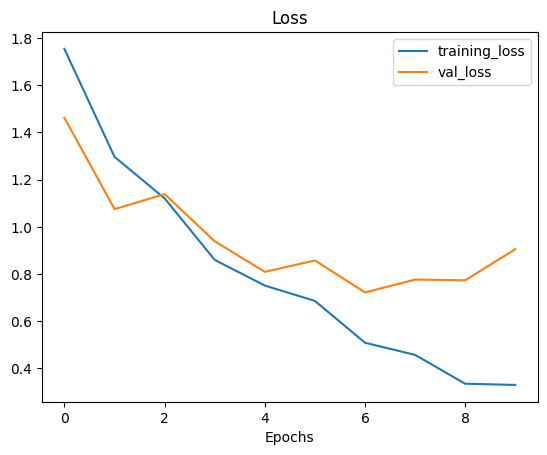

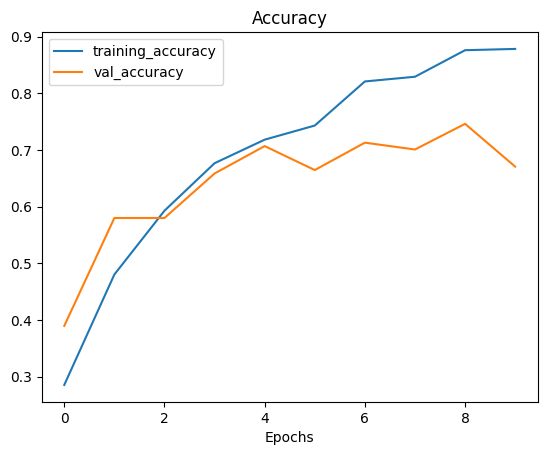

In [9]:
plot_loss_curves(history)

## **Base Model (ResNet50)**
* **Architecture:** ResNet50 is a 50-layer deep convolutional network known for its residual connections, which help avoid the vanishing gradient problem, allowing efficient training of deep networks.
* **Pre-training:** The model is pre-trained on the ImageNet dataset, which contains millions of images classified into thousands of categories. This pre-training helps the model learn a wide range of features that can be useful for various image classification tasks.
* **Adaptation:** The top (classification) layer of the ResNet50 model is removed to allow for customization to the specific task (classifying fresh and rotten fruits in this case).


### Custom Top Layers
- **Global Average Pooling 2D Layer:** Reduces the spatial dimensions (height and width) of the output from the ResNet50 base model to a single 2D tensor per feature map. This helps in reducing the number of parameters and computational complexity.
- **Dense Layer:** A fully connected layer with 1024 neurons and ReLU activation function. It serves to learn non-linear combinations of the high-level features extracted by the base model.
- **Dropout Layer:** With a rate of 0.2, it randomly sets input units to 0 at each step during training time, which helps prevent overfitting.
- **Output Layer:** A dense layer with a softmax activation function that outputs the probabilities for each of the six classes (fresh and rotten for each of the three fruit types).

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_transfer_learning_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 6 classes for the fruits
transfer_learning_model = create_transfer_learning_model((100, 100, 3), 6)
transfer_learning_model.summary()


/tmp/ipykernel_19/641549578.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 50, 50,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 50, 50,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 50, 50,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 50, 50,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 50, 50,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 50, 50,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 51, 51,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 25, 25,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 25, 25,    │      2,304 │ block_1_depthwis

 Total params: 3,575,878 (13.64 MB)

 Trainable params: 1,317,894 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# First, train with the base layers frozen
history_tl = transfer_learning_model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.6206 - loss: 1.6686 - val_accuracy: 0.8671 - val_loss: 0.4108
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.8915 - loss: 0.3195 - val_accuracy: 0.8610 - val_loss: 0.3565
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9447 - loss: 0.1764 - val_accuracy: 0.8731 - val_loss: 0.3503
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9808 - loss: 0.0781 - val_accuracy: 0.8943 - val_loss: 0.3083
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9895 - loss: 0.0495 - val_accuracy: 0.9094 - val_loss: 0.2695
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.8943 - val_loss: 0.2811
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9998 - loss: 0.0110 - val_accuracy: 0.9094 - val_loss: 0.2606
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 

# predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


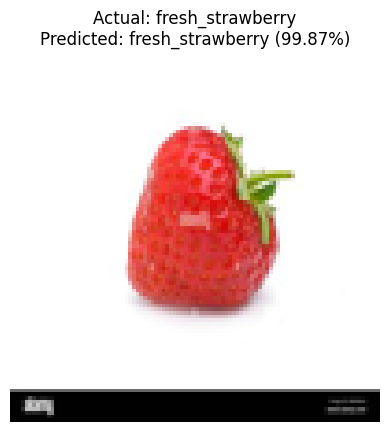

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Randomly pick an image from the validation set
random_index = np.random.randint(0, len(val_images))
sample_image = val_images[random_index]
sample_label = val_labels[random_index]

# Predict the class for the selected image
prediction = transfer_learning_model.predict(np.expand_dims(sample_image, axis=0))
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

# Get the label name (reverse from encoded to actual name)
predicted_label = label_encoder.inverse_transform([predicted_class])[0]

# Plot the image
plt.imshow(sample_image)
plt.title(f"Actual: {label_encoder.inverse_transform([sample_label])[0]}\nPredicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.axis('off')
plt.show()